In [1]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

from Tusc5ImageUtils import *
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, plot, models, denoise
from scipy.ndimage import binary_erosion, binary_fill_holes, center_of_mass
from scipy.signal import find_peaks
import subprocess
import pandas as pd
import nd2
from skimage.measure import regionprops

Current Working Directory: /Users/raphaeltinio/Lab Analysis MAC/ImageAnalysis


In [2]:
### Directory Configuration ###

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, 'Test Stacks')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V1')
img_path = os.path.join(test_stacks_directory, '2007R_GLUT1_647_WGA_594_0002.nd2')

In [ ]:
### Image Insertion ###

f = nd2.ND2File(img_path)
z_sep = f.voxel_size().z
image = f.asarray()

DAPI_stack = to_8bit(image[:,0,:,:].copy())
eGFP_stack = to_8bit(image[:,1,:,:].copy())
WGA_stack = to_8bit(image[:,2,:,:].copy())
GLUT1_stack = to_8bit(image[:,3,:,:].copy())

mp_DAPI = max_proj(DAPI_stack)
model = models.CellposeModel(pretrained_model=model_path_dapi)
DAPI_masks, flows, styles = model.eval(mp_DAPI, diameter=None, channels=[0,0])

/var/folders/sl/syqsj8q94yn7kbv8l50mtwdw0000gn/T/ipykernel_48690/3179133809.py:3: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(img_path)


# Cell Fluoresence Retrieval

In [3]:
parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_dir = os.path.join(parent_directory, 'Test Stacks')

In [4]:
script = f'POSIX path of (choose folder default location "{current_directory}")'
selected_folder = subprocess.check_output(['osascript', '-e', script]).decode('utf-8').strip()
nd2_files = [f for f in os.listdir(selected_folder) if f.endswith('.nd2')]
#PC selected_folder = os.path.normpath('D:\Lab Analysis PC\Test Stacks')
#nd2_files = [f for f in os.listdir(os.path.normpath('D:\Lab Analysis PC\Test Stacks')) if f.endswith('.nd2')]

### Model Paths ###
model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V3')
model_path_wga = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_WGA_V2')

all_data = pd.DataFrame()
unid_counter = 0

for nd2_file in nd2_files:

    # 1) Download Image Data
    print(f'Processing {nd2_file}')
    nd2_path = os.path.join(selected_folder, nd2_file)

    f = nd2.ND2File(nd2_path)
    z_sep = f.voxel_size().z
    image = f.asarray()

    # 2) DAPI max projection, Deblur, Segment
    DAPI_stack = to_8bit(image[:,0,:,:].copy())
    mp_DAPI = max_proj(DAPI_stack)

    # 3) Deblur and Segment DAPI max projection
    deblur_model = denoise.CellposeDenoiseModel(gpu=True, model_type = model_path_dapi, restore_type="deblur_cyto3")
    DAPI_masks, flows, styles, image_deblurred = deblur_model.eval(auto_brightness_contrast(mp_DAPI), diameter=90, channels=[0,0])

    image_deblurred = image_deblurred[:,:,0] # resulting image has one channel, but it still needs to be indexed 

    # DAPI filtering and eGFP identification

    '''
    Indiviudal Cell
    '''

    # 5) Segmentation of WGA channel

    mask_idxs = np.delete(np.unique(DAPI_masks), 0) - 1

    for mask_id in mask_idxs:

        
        single_mask = extract_masks(DAPI_masks, mask_id)
        diam = get_mask_diameter(single_mask)
        expansion = 50

        sq_stacks = get_sq_stacks(image, single_mask)
        
        # Running the model of the expanded squares
        expanded_sq_WGA = extract_square_proj_expand(image, single_mask, expansion)

        model = models.CellposeModel(gpu = True, pretrained_model = model_path_wga)
        expanded_mask, flows, styles = model.eval(expanded_sq_WGA, diameter=diam, channels=[0,0])

        # Removing 0-pixel boundary and finding the largest mask in the array
        WGA_mask = remove_boundary(expanded_mask, expansion)

        if len(np.unique(WGA_mask)) == 1:
            print('No mask found.')
            continue

        largest_idx = np.argmax(utils.diameters(WGA_mask)[1])
        WGA_mask = extract_masks(WGA_mask, largest_idx)

        # Z-axis profile
        trace_results = get_traces(sq_stacks, WGA_mask)

        '''
        Organizing data
        '''
        
        # 6) Converting trace results into a pd dataframe
        dataframe = organize_data(trace_results, mask_id)

        # 7) Adding file information
        djid, eye, file_base = extract_information(nd2_file)

        nested_array = np.array(range(image.shape[0]))* f.voxel_size().z
        dataframe['X_vals'] = [nested_array for i in range(len(dataframe))]
        dataframe['file_name'] = file_base
        dataframe['DJID'] = djid
        dataframe['Eye'] = eye

        # 8) cell_unid information
        unique_mask_ids = dataframe['mask_id'].unique()
        mask_id_to_unid = {mask_id: unid_counter + i for i, mask_id in enumerate(unique_mask_ids)}
        dataframe['unid'] = dataframe['mask_id'].map(mask_id_to_unid)
        unid_counter += len(unique_mask_ids)

        # 9) Concatenation with existing data
        all_data = pd.concat([all_data, dataframe], ignore_index=True)

Processing 3203R_GLUT1_647_WGA_594_0002.nd2
No mask found.
No mask found.
No mask found.
No mask found.
No mask found.
No mask found.
No mask found.


In [10]:
test = models.CellposeModel(gpu = True, pretrained_model = 'cyto3')
test_mask, flows, styles = model.eval(mp_DAPI, diameter=diam, channels=[0,0])

(-0.5, 1023.5, 1023.5, -0.5)

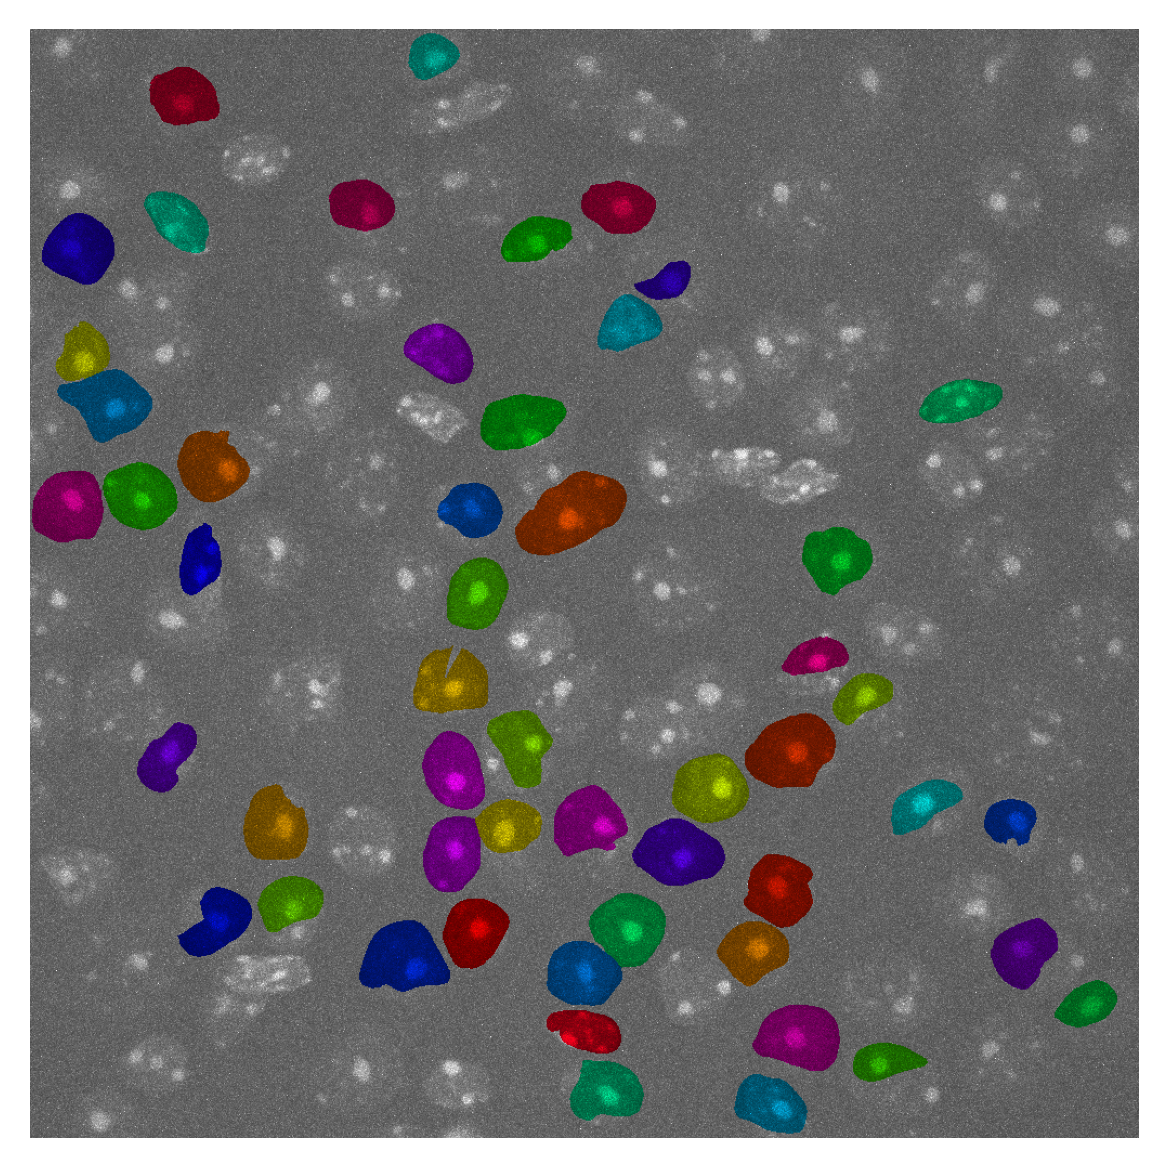

In [11]:
over = plot.mask_overlay(mp_DAPI, test_mask)
plt.imshow(over)
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

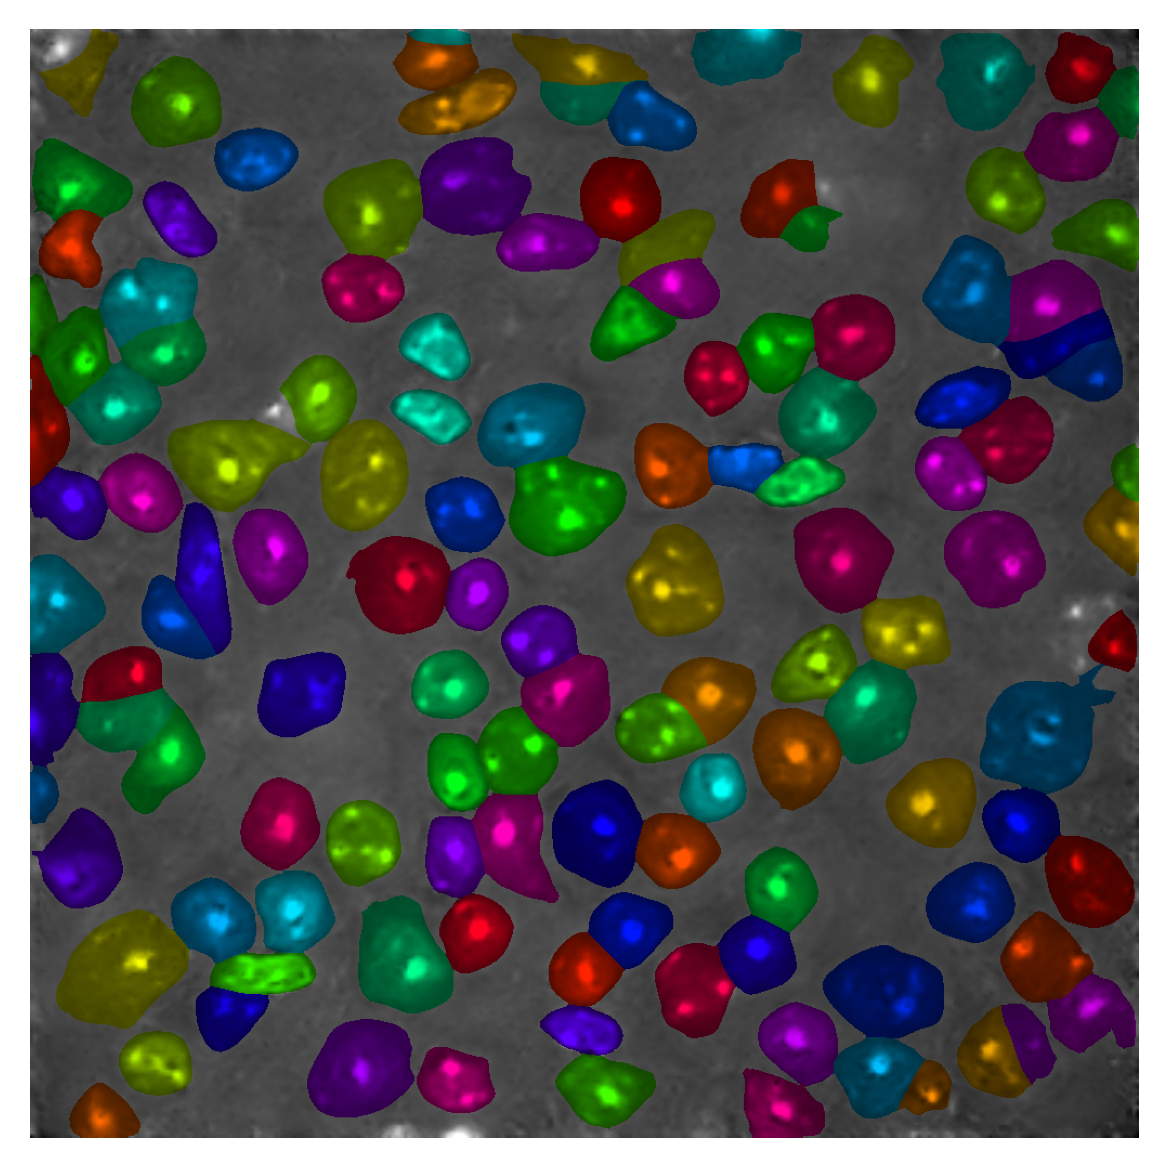

In [7]:
over = plot.mask_overlay(to_8bit(image_deblurred), DAPI_masks)
plt.imshow(over)
plt.axis('off')

/Users/raphaeltinio/Lab Analysis MAC/ImageAnalysis/Tusc5ImageUtils.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_cell['Stain'] = single_cell['Stain'].apply(lambda x: 'GluT1' if x == 'GluT1' else x)


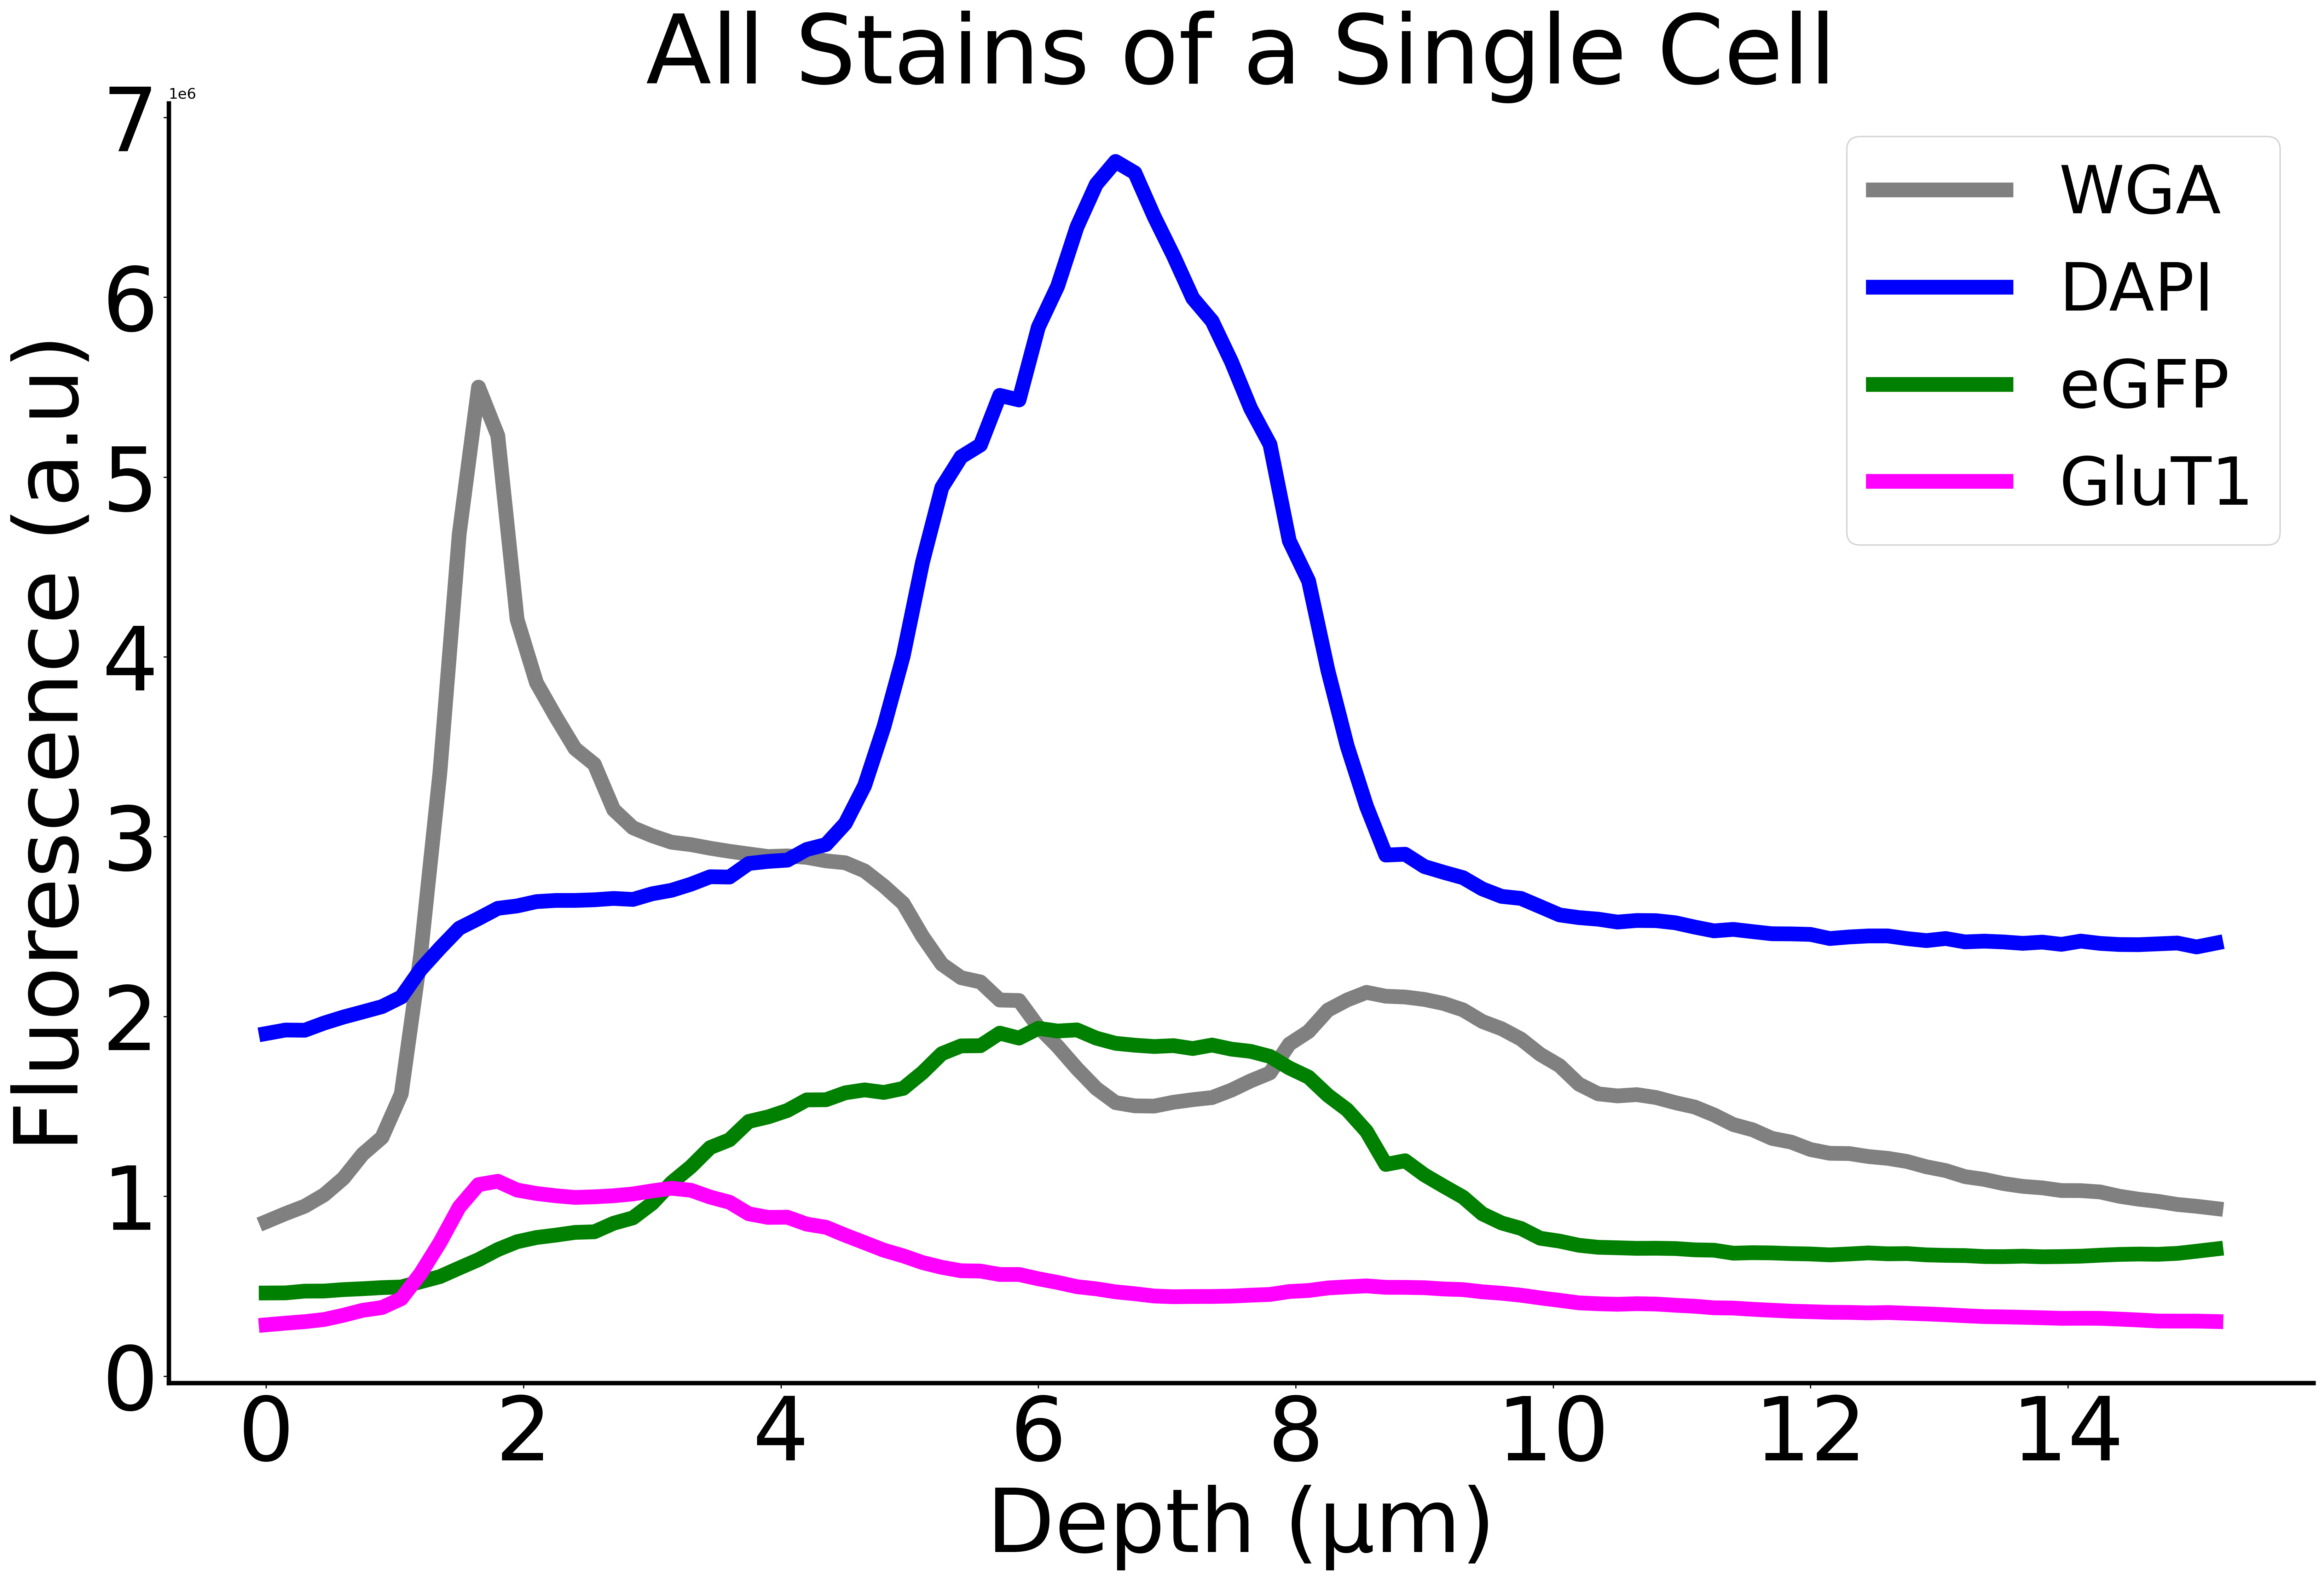

In [9]:
from scipy.signal import find_peaks

single_cell = all_data.query('unid == 30')
plot_single_cell(single_cell)